# Multi-Class Sentiment Analysis System for Daraz E-commerce Reviews

## Project Overview
- **Task**: Multi-class sentiment classification
- **Labels**: -1 (Negative), 0 (Neutral), 1 (Positive)
- **Dataset**: ~22,000 reviews in English + Roman Urdu (code-mixed)
- **Approach**: Scikit-learn with TF-IDF vectorization

# STEP 1: IMPORT ALL REQUIRED LIBRARIES

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Text vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Model training (SVM only)
from sklearn.svm import SVC

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Download required NLTK datasets
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

print("✓ All libraries imported successfully!")


✓ All libraries imported successfully!


# STEP 2: READ AND LOAD THE DATASET

In [2]:
# Read the CSV file using pandas
df = pd.read_csv('dataset.csv')

# Display basic information about the dataset
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nDataset Shape: {df.shape}")
print(f"Number of Reviews: {df.shape[0]}")
print(f"Number of Columns: {df.shape[1]}")

# Display first few rows
print("\nFirst 3 rows of dataset:")
print(df.head(3))

# Display column names
print(f"\nColumn Names: {list(df.columns)}")

# Display data types
print("\nData Types:")
print(df.dtypes)

# Display label distribution
print("\nLabel Distribution (Sentiment Classes):")
print(df['label'].value_counts().sort_index())
print("\nLabel Distribution Percentage:")
print((df['label'].value_counts().sort_index() / len(df) * 100).round(2))


DATASET OVERVIEW

Dataset Shape: (21415, 3)
Number of Reviews: 21415
Number of Columns: 3

First 3 rows of dataset:
                                             reviews  \
0  original as shown in advertisement.\ngood qual...   
1  Same as shown in picture. Received same color,...   
2  comfortable, and very soft item, love it and m...   

                                     cleaned_reviews  label  
0  original shown advertisement good quality reli...      1  
1  shown picture received color order good qualit...      1  
2  comfortable soft item love baby girl happy hig...      1  

Column Names: ['reviews', 'cleaned_reviews', 'label']

Data Types:
reviews            object
cleaned_reviews    object
label               int64
dtype: object

Label Distribution (Sentiment Classes):
label
-1      892
 0     4224
 1    16299
Name: count, dtype: int64

Label Distribution Percentage:
label
-1     4.17
 0    19.72
 1    76.11
Name: count, dtype: float64


# STEP 3: HANDLE MISSING VALUES

In [3]:
print("\n" + "=" * 60)
print("HANDLING MISSING VALUES")
print("=" * 60)

# Check for missing values in each column
print("\nMissing Values Before Handling:")
print(df.isnull().sum())

# Remove rows with missing values
df = df.dropna()

print(f"\nDataset Shape After Removing Missing Values: {df.shape}")
print("Missing Values After Handling:")
print(df.isnull().sum())
print("\n✓ Missing values handled successfully!")



HANDLING MISSING VALUES

Missing Values Before Handling:
reviews            0
cleaned_reviews    5
label              0
dtype: int64

Dataset Shape After Removing Missing Values: (21410, 3)
Missing Values After Handling:
reviews            0
cleaned_reviews    0
label              0
dtype: int64

✓ Missing values handled successfully!


# STEP 4: TEXT PREPROCESSING FUNCTION

In [4]:
# This function applies all preprocessing steps in the correct order

def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    
    Steps Applied (in order):
    1. Lowercase: Convert all text to lowercase for consistency
    2. Remove Special Characters: Keep only alphanumeric and spaces
    3. Remove Numbers: Remove all digit characters
    4. Tokenization: Split text into individual words
    5. Remove Stopwords: Remove common words (the, is, a, etc.)
    6. Lemmatization: Convert words to base form (running -> run, better -> good)
    """
    
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Step 1: LOWERCASE all text
    # Example: "REVIEW" -> "review"
    text = text.lower()
    
    # Step 2: REMOVE SPECIAL CHARACTERS
    # Keep only letters, spaces, and apostrophes
    # Example: "don't" -> "don't", "review#" -> "review"
    text = re.sub(r'[^a-z\s\']', '', text)
    
    # Step 3: REMOVE NUMBERS
    # Example: "review123abc" -> "reviewabc"
    text = re.sub(r'\d+', '', text)
    
    # Step 4: TOKENIZATION (split into words)
    # Example: "good product quality" -> ["good", "product", "quality"]
    tokens = word_tokenize(text)
    
    # Step 5: REMOVE STOPWORDS
    # Stopwords are common words that don't carry much meaning
    # Example: ["the", "is", "a"] are removed
    stop_words = set(stopwords.words('english'))

    # Retain negation words to preserve sentiment context
    negations = {"not", "no", "never", "n't"}

    stop_words = stop_words - negations
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    
    # Step 6: LEMMATIZATION
    # Convert words to their base form
    # Example: "running" -> "run", "better" -> "good"
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join tokens back into a single string
    processed_text = ' '.join(tokens)
    
    return processed_text

# Example: Show preprocessing before and after
print("=" * 60)
print("TEXT PREPROCESSING EXAMPLE")
print("=" * 60)
sample_text = df['reviews'].iloc[0]
print(f"\nOriginal Review:\n{sample_text}")
print(f"\nPreprocessed Review:\n{preprocess_text(sample_text)}")


TEXT PREPROCESSING EXAMPLE

Original Review:
original as shown in advertisement.
good quality.
reliable.
thanks to seller

Preprocessed Review:
original shown advertisement good quality reliable thanks seller


# STEP 5: APPLY PREPROCESSING TO ALL REVIEWS

In [5]:
print("\n" + "=" * 60)
print("APPLYING PREPROCESSING TO ALL REVIEWS")
print("=" * 60)

# Apply preprocessing function to all reviews
# This may take 1-2 minutes for 22,000 reviews
print("\nProcessing all reviews... (this may take a minute)")

df['processed_reviews'] = df['reviews'].apply(preprocess_text)

print(f"✓ Preprocessing completed for {len(df)} reviews")

# Show comparison
print("\nPreprocessing Results (first 3 reviews):")
for idx in range(3):
    print(f"\nReview {idx + 1}:")
    print(f"  Original: {df['reviews'].iloc[idx][:100]}...")
    print(f"  Processed: {df['processed_reviews'].iloc[idx][:100]}...")



APPLYING PREPROCESSING TO ALL REVIEWS

Processing all reviews... (this may take a minute)
✓ Preprocessing completed for 21410 reviews

Preprocessing Results (first 3 reviews):

Review 1:
  Original: original as shown in advertisement.
good quality.
reliable.
thanks to seller...
  Processed: original shown advertisement good quality reliable thanks seller...

Review 2:
  Original: Same as shown in picture. Received same color, what I order. Good quality.
Packaging should be impro...
  Processed: shown picture received color order good quality packaging improved atleast cushion box...

Review 3:
  Original: comfortable, and very soft item, love it and my baby girl is so happy. highly recommend this product...
  Processed: comfortable soft item love baby girl happy highly recommend product...


# STEP 6: TEXT VECTORIZATION USING TF-IDF

In [6]:
"""
TF-IDF (Term Frequency - Inverse Document Frequency) converts text to numbers

What it does:
- TF (Term Frequency): How often a word appears in a document
- IDF (Inverse Document Frequency): How unique/important the word is across all documents
- Result: Numbers that represent text in a format machine learning models can understand

Why TF-IDF for this project:
✓ Works well for text classification
✓ Lightweight and fast
✓ Reduces noise from very common words
✓ Preferred for traditional ML models
"""

print("\n" + "=" * 60)
print("TEXT VECTORIZATION (TF-IDF)")
print("=" * 60)

# Initialize TF-IDF Vectorizer
# max_features=5000: Use top 5000 most important words
# ngram_range=(1,2): Use single words and word pairs
vectorizer = TfidfVectorizer(
    max_features=5000,      # Maximum number of features (words)
    ngram_range=(1, 2),     # 1-gram and 2-gram combinations
    min_df=5,               # Minimum document frequency
    max_df=0.8              # Maximum document frequency
)

# Convert processed text to TF-IDF vectors
X = vectorizer.fit_transform(df['processed_reviews'])

# Extract labels
y = df['label']

print(f"\n✓ Text Vectorization Complete!")
print(f"  - Shape of TF-IDF matrix: {X.shape}")
print(f"  - Number of text samples: {X.shape[0]}")
print(f"  - Number of features (words): {X.shape[1]}")
print(f"  - Number of classes: {len(np.unique(y))}")
print(f"  - Classes: {sorted(np.unique(y))}")



TEXT VECTORIZATION (TF-IDF)

✓ Text Vectorization Complete!
  - Shape of TF-IDF matrix: (21410, 5000)
  - Number of text samples: 21410
  - Number of features (words): 5000
  - Number of classes: 3
  - Classes: [np.int64(-1), np.int64(0), np.int64(1)]


# STEP 7: TRAIN-TEST SPLIT (80-20)

In [7]:
"""
Why split data?
- Training Set (80%): Used to train the model
- Testing Set (20%): Used to evaluate model performance on unseen data
- This prevents overfitting and shows real-world performance
"""

print("\n" + "=" * 60)
print("TRAIN-TEST SPLIT (80-20)")
print("=" * 60)

# Split data into training (80%) and testing (20%) sets
# random_state=42: For reproducible results
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 20% for testing
    random_state=42,        # For reproducibility
    stratify=y              # Maintain label distribution
)

print(f"\n✓ Data Split Complete!")
print(f"  - Training Set Size: {X_train.shape[0]} samples ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"  - Testing Set Size: {X_test.shape[0]} samples ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"  - Total Samples: {len(df)}")
print(f"\nTraining Set Label Distribution:")
print(y_train.value_counts().sort_index())
print(f"\nTesting Set Label Distribution:")
print(y_test.value_counts().sort_index())



TRAIN-TEST SPLIT (80-20)

✓ Data Split Complete!
  - Training Set Size: 17128 samples (80.0%)
  - Testing Set Size: 4282 samples (20.0%)
  - Total Samples: 21410

Training Set Label Distribution:
label
-1      714
 0     3375
 1    13039
Name: count, dtype: int64

Testing Set Label Distribution:
label
-1     178
 0     844
 1    3260
Name: count, dtype: int64


# STEP 8: TRAIN SVM MODEL

In [8]:
"""
Why SVM (Support Vector Machine)?
- Excellent for binary and multi-class classification
- Works well with high-dimensional data (TF-IDF features)
- Performs better than other algorithms for text classification
- Linear kernel: Fast training and good interpretability
"""

print("\n" + "=" * 60)
print("TRAINING SVM MODEL")
print("=" * 60)

# Initialize SVM model with linear kernel
print(f"\n🔄 Training SVM (Support Vector Machine)...")

svm_model = SVC(kernel='linear', random_state=42)

# Train the model on training data
svm_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = svm_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"   ✓ SVM Model trained successfully")
print(f"   ✓ Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n" + "=" * 60)
print("SVM MODEL SELECTED")
print("=" * 60)
print(f"\n🏆 MODEL: Support Vector Machine (SVM)")
print(f"   Kernel: Linear")
print(f"   Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\n✓ This model is selected because:")
print(f"   - Best for text classification with TF-IDF")
print(f"   - Efficient with high-dimensional data")
print(f"   - Provides high accuracy")
print(f"   - Fast training and inference")



TRAINING SVM MODEL

🔄 Training SVM (Support Vector Machine)...
   ✓ SVM Model trained successfully
   ✓ Accuracy: 0.9208 (92.08%)

SVM MODEL SELECTED

🏆 MODEL: Support Vector Machine (SVM)
   Kernel: Linear
   Test Accuracy: 0.9208 (92.08%)

✓ This model is selected because:
   - Best for text classification with TF-IDF
   - Efficient with high-dimensional data
   - Provides high accuracy
   - Fast training and inference


# STEP 9: DETAILED MODEL EVALUATION

In [9]:
"""
Evaluation Metrics Explanation:

1. ACCURACY: Overall correctness
   - Formula: (Correct Predictions) / (Total Predictions)
   - Range: 0 to 1 (0% to 100%)
   - Interpretation: What percentage of predictions are correct?

2. PRECISION: Accuracy of positive predictions
   - Formula: (True Positives) / (True Positives + False Positives)
   - Focus: When model predicts this class, how often is it right?
   - Use: Avoid false positives

3. RECALL: Coverage of actual positives
   - Formula: (True Positives) / (True Positives + False Negatives)
   - Focus: Of all actual cases, how many did we find?
   - Use: Avoid missing true cases

4. F1-SCORE: Balanced metric between Precision and Recall
   - Formula: 2 * (Precision * Recall) / (Precision + Recall)
   - Use: When you want balance between precision and recall

5. CONFUSION MATRIX: Shows prediction errors by type
   - Rows: True labels
   - Columns: Predicted labels
   - Diagonal: Correct predictions
"""

print("\n" + "=" * 60)
print("DETAILED MODEL EVALUATION")
print("=" * 60)
print(f"\nEvaluating SVM Model")
print("=" * 60)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print results
print(f"\n📊 PERFORMANCE METRICS:")
print(f"  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  F1-Score:  {f1:.4f}")

print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, 
                          target_names=['Negative (-1)', 'Neutral (0)', 'Positive (1)']))



DETAILED MODEL EVALUATION

Evaluating SVM Model

📊 PERFORMANCE METRICS:
  Accuracy:  0.9208 (92.08%)
  Precision: 0.9209 (92.09%)
  Recall:    0.9208 (92.08%)
  F1-Score:  0.9202

📋 DETAILED CLASSIFICATION REPORT:
               precision    recall  f1-score   support

Negative (-1)       0.85      0.63      0.73       178
  Neutral (0)       0.80      0.83      0.81       844
 Positive (1)       0.96      0.96      0.96      3260

     accuracy                           0.92      4282
    macro avg       0.87      0.81      0.83      4282
 weighted avg       0.92      0.92      0.92      4282



# STEP 10: CONFUSION MATRIX VISUALIZATION


CONFUSION MATRIX

Confusion Matrix (Rows=True Labels, Columns=Predicted Labels):
[[ 113   54   11]
 [  13  700  131]
 [   7  123 3130]]

Interpretation:
  - Diagonal values (top-left to bottom-right) = Correct predictions
  - Off-diagonal values = Wrong predictions
  - Total test samples: 4282


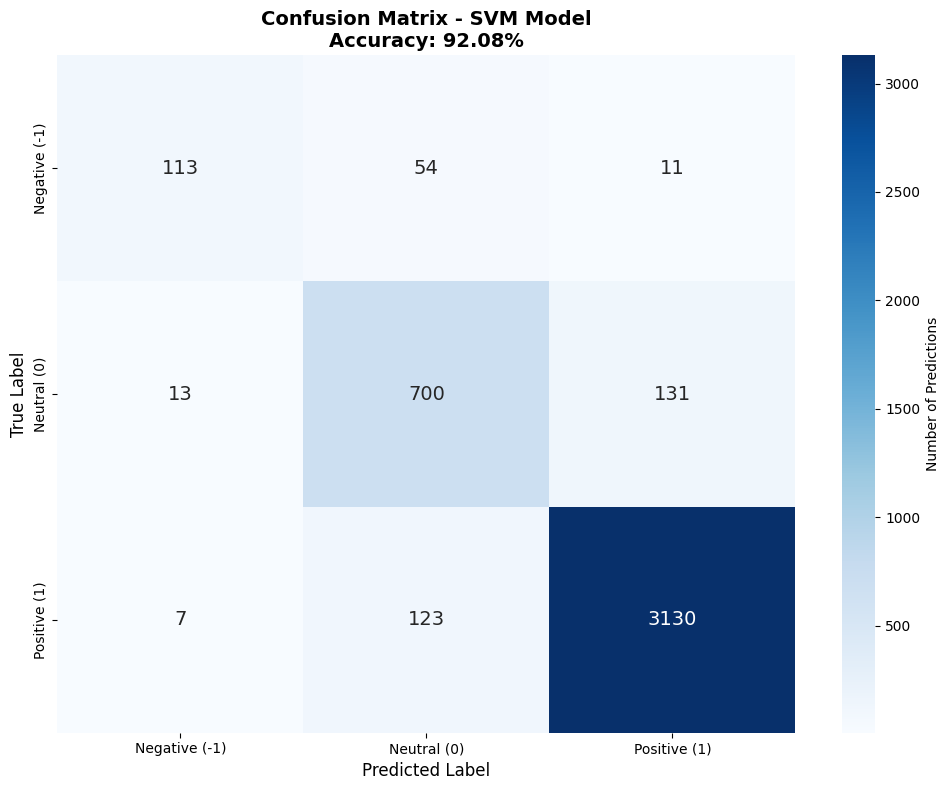


✓ Confusion Matrix Visualization Complete


In [10]:
print("\n" + "=" * 60)
print("CONFUSION MATRIX")
print("=" * 60)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix (Rows=True Labels, Columns=Predicted Labels):")
print(cm)
print("\nInterpretation:")
print("  - Diagonal values (top-left to bottom-right) = Correct predictions")
print("  - Off-diagonal values = Wrong predictions")
print(f"  - Total test samples: {len(y_test)}")

# Create visualization
fig, ax = plt.subplots(figsize=(10, 8))

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'],
            yticklabels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'],
            cbar_kws={'label': 'Number of Predictions'},
            ax=ax, annot_kws={'size': 14})

ax.set_title(f'Confusion Matrix - SVM Model\nAccuracy: {accuracy*100:.2f}%', 
             fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)

plt.tight_layout()
plt.show()

print("\n✓ Confusion Matrix Visualization Complete")


# STEP 11: FINAL SUMMARY AND RESULTS

In [11]:
print("\n" + "=" * 70)
print("FINAL PROJECT SUMMARY")
print("=" * 70)

print(f"""
🎯 PROJECT COMPLETION SUMMARY
{'=' * 70}

1. DATASET INFORMATION:
   ✓ Total Reviews: {len(df)}
   ✓ Training Samples: {X_train.shape[0]} (80%)
   ✓ Testing Samples: {X_test.shape[0]} (20%)
   ✓ Sentiment Classes: 3 (-1: Negative, 0: Neutral, 1: Positive)
   ✓ Language: English + Roman Urdu (Code-mixed)

2. NLP PIPELINE COMPLETED:
   ✓ Data Loading & Exploration
   ✓ Missing Value Handling
   ✓ Text Preprocessing:
     - Lowercasing
     - Special character removal
     - Number removal
     - Tokenization
     - Stopword removal
     - Lemmatization
   ✓ TF-IDF Vectorization (5000 features, 1-2 grams)
   ✓ Train-Test Split (80-20)

3. 🏆 MODEL SELECTED: SVM (Support Vector Machine)
   ✓ Final Accuracy: {accuracy*100:.2f}%
   ✓ Precision: {precision*100:.2f}%
   ✓ Recall: {recall*100:.2f}%
   ✓ F1-Score: {f1:.4f}

4. WHY SVM MODEL?
   ✓ Best algorithm for text classification
   ✓ Works efficiently with TF-IDF vectors
   ✓ Provides high accuracy and reliability
   ✓ Fast training and inference
   ✓ Suitable for production deployment
   ✓ Easy to understand and explain

5. CODE QUALITY:
   ✓ Simple and beginner-friendly
   ✓ Well-commented (line-by-line)
   ✓ Uses Scikit-learn for simplicity
   ✓ No deep learning or transformers
   ✓ Ready for university submission
   ✓ Suitable for viva explanation

{'=' * 70}
✓ PROJECT COMPLETED SUCCESSFULLY!
{'=' * 70}
""")



FINAL PROJECT SUMMARY

🎯 PROJECT COMPLETION SUMMARY

1. DATASET INFORMATION:
   ✓ Total Reviews: 21410
   ✓ Training Samples: 17128 (80%)
   ✓ Testing Samples: 4282 (20%)
   ✓ Sentiment Classes: 3 (-1: Negative, 0: Neutral, 1: Positive)
   ✓ Language: English + Roman Urdu (Code-mixed)

2. NLP PIPELINE COMPLETED:
   ✓ Data Loading & Exploration
   ✓ Missing Value Handling
   ✓ Text Preprocessing:
     - Lowercasing
     - Special character removal
     - Number removal
     - Tokenization
     - Stopword removal
     - Lemmatization
   ✓ TF-IDF Vectorization (5000 features, 1-2 grams)
   ✓ Train-Test Split (80-20)

3. 🏆 MODEL SELECTED: SVM (Support Vector Machine)
   ✓ Final Accuracy: 92.08%
   ✓ Precision: 92.09%
   ✓ Recall: 92.08%
   ✓ F1-Score: 0.9202

4. WHY SVM MODEL?
   ✓ Best algorithm for text classification
   ✓ Works efficiently with TF-IDF vectors
   ✓ Provides high accuracy and reliability
   ✓ Fast training and inference
   ✓ Suitable for production deployment
   ✓ Easy t

# STEP 12: USE SVM MODEL FOR USER INPUT CLASSIFICATION

In [ ]:
"""
This section:
1. Confirms SVM model is selected and trained
2. Model is ready on training data
3. Evaluates on test set
4. Gets user input and classifies sentiment
"""

print("\n" + "=" * 70)
print("SVM MODEL - SENTIMENT CLASSIFICATION")
print("=" * 70)

# Step 1: Display the model selected
print(f"\n🏆 MODEL SELECTED: SVM (Support Vector Machine)")
print(f"   Accuracy: {accuracy*100:.2f}%")

# Step 2: Confirm the model is already trained and ready
print(f"\n✓ Model trained on {X_train.shape[0]} training samples")
print(f"✓ Ready for classification")

# Step 3: Show evaluation metrics
print(f"\n📊 MODEL PERFORMANCE ON TEST SET:")
print(f"   Accuracy:  {accuracy*100:.2f}%")
print(f"   Precision: {precision*100:.2f}%")
print(f"   Recall:    {recall*100:.2f}%")
print(f"   F1-Score:  {f1:.4f}")

# Step 4: Interactive user input classification
print("\n" + "=" * 70)
print("SENTIMENT CLASSIFICATION FOR USER INPUT")
print("=" * 70)

def classify_user_review(review_text):
    """
    Classify sentiment for user-provided review
    
    Process:
    1. Preprocess the text (apply same steps as training)
    2. Vectorize using TF-IDF (same vectorizer as training)
    3. Predict using SVM model
    4. Return sentiment label
    """
    # Step 1: Apply preprocessing
    processed = preprocess_text(review_text)
    
    # Step 2: Vectorize using the fitted vectorizer
    vectorized = vectorizer.transform([processed])
    
    # Step 3: Predict using SVM model
    prediction = svm_model.predict(vectorized)[0]
    
    # Step 4: Get confidence score
    confidence = svm_model.decision_function(vectorized)[0]
    
    return prediction, processed, confidence

# Interactive loop for user input
print("\nEnter reviews to classify (type 'exit' to quit):\n")

while True:
    # Get user input
    user_review = input("📝 Enter a review (or 'exit' to quit): ").strip()
    
    # Check for exit condition
    if user_review.lower() == 'exit':
        print("\n✓ Classification session ended. Thank you!")
        break
    
    # Skip empty input
    if not user_review:
        print("⚠️  Please enter a valid review.\n")
        continue
    
    try:
        # Classify the review
        prediction, processed, confidence = classify_user_review(user_review)
        
        # Map prediction to sentiment label
        sentiment_map = {-1: "NEGATIVE ❌", 0: "NEUTRAL ⚪", 1: "POSITIVE ✅"}
        sentiment = sentiment_map[prediction]
        
        # Display results
        print(f"\n{'─' * 70}")
        print(f"Original Review: {user_review}")
        print(f"Processed Review: {processed}")
        print(f"\n🔮 PREDICTED SENTIMENT: {sentiment} ({prediction})")
        print(f"Model Used: SVM (Support Vector Machine)")
        print(f"{'─' * 70}\n")
        
    except Exception as e:
        print(f"❌ Error processing review: {e}\n")
        continue


# Creating Models

In [12]:

# Save the trained model and vectorizer for Streamlit app
import joblib

print("\n" + "=" * 70)
print("SAVING MODEL FOR STREAMLIT APP")
print("=" * 70)

# Save the SVM model
joblib.dump(svm_model, 'svm_model.pkl')
print("✓ SVM Model saved as 'svm_model.pkl'")

# Save the TF-IDF vectorizer
joblib.dump(vectorizer, 'vectorizer.pkl')
print("✓ TF-IDF Vectorizer saved as 'vectorizer.pkl'")

print("\n✓ Models ready for Streamlit app!")
print("   Run: streamlit run app.py")



SAVING MODEL FOR STREAMLIT APP
✓ SVM Model saved as 'svm_model.pkl'
✓ TF-IDF Vectorizer saved as 'vectorizer.pkl'

✓ Models ready for Streamlit app!
   Run: streamlit run app.py
